<a href="https://colab.research.google.com/github/MichM072/ScriptieRec/blob/main/Scriptie_librec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pip installations
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

local = os.path.isdir('data/movielens_100k/ml-100k/')

if local:
    path = 'data/movielens_100k/ml-100k/'
else:
    path = '/kaggle/input/movielens-100k-dataset/ml-100k/'
#     if not os.path.isdir('/content/drive/MyDrive/ml-100k/'):
#         from google.colab import drive
#         drive.mount('/content/drive')
#         path = '/content/drive/MyDrive/ml-100k/'

if not local:
  !pip install surprise
  !pip install LibRecommender
  !pip install ray -U "ray[tune]"

/kaggle/input/movielens-100k-dataset/ml-100k/u.occupation
/kaggle/input/movielens-100k-dataset/ml-100k/u1.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.info
/kaggle/input/movielens-100k-dataset/ml-100k/u4.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.item
/kaggle/input/movielens-100k-dataset/ml-100k/README
/kaggle/input/movielens-100k-dataset/ml-100k/u1.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.data
/kaggle/input/movielens-100k-dataset/ml-100k/u5.test
/kaggle/input/movielens-100k-dataset/ml-100k/mku.sh
/kaggle/input/movielens-100k-dataset/ml-100k/u5.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.user
/kaggle/input/movielens-100k-dataset/ml-100k/ub.base
/kaggle/input/movielens-100k-dataset/ml-100k/u4.base
/kaggle/input/movielens-100k-dataset/ml-100k/u2.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.base
/kaggle/input/movielens-100k-dataset/ml-100k/u3.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc
from surprise import Dataset
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import DistanceMetric
from sklearn import preprocessing
import tensorflow as tf

In [3]:
user_cols = ['userId',  'age',  'gender',  'occupation',  'zip code']
user_data = pd.read_csv(path + 'u.user', sep='|', names=user_cols)

rating_cols = ['userId' , 'itemId','rating', 'timestamp']
rating_matrix = pd.read_csv(path + 'u.data', sep='\t', names=rating_cols).sort_values(by='userId', ascending=True).reset_index(drop=True)

item_cols = ['itemId', 'movieTitle', 'releaseDate', 'videoReleaseDate', 
        'IMDb-URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_matrix = pd.read_csv(path + 'u.item', sep='|', names = item_cols, encoding = 'unicode_escape', engine ='python')

In [4]:
df_data = rating_matrix.merge(user_data, on='userId').merge(item_matrix, on='itemId')

df_data.head()

userId  itemId  rating  timestamp  age gender     occupation zip code  \
0       1      55       5  875072688   24      M     technician    85711   
1       8      55       5  879362286   36      M  administrator    05201   
2      16      55       5  877717956   21      M  entertainment    10309   
3      23      55       4  874785624   30      F         artist    48197   
4      24      55       5  875323308   21      F         artist    94533   

                 movieTitle  releaseDate  ...  Fantasy Film-Noir  Horror  \
0  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
1  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
2  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
3  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
4  Professional, The (1994)  01-Jan-1994  ...        0         0       0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        1       0         1    0        0  
1        0        0        1       0         1    0        0  
2        0        0        1       0         1    0        0  
3        0        0        1       0         1    0        0  
4        0        0        1       0         1    0        0  

[5 rows x 31 columns]

In [5]:
day_split = 86400

from libreco.data import random_split

df_data = df_data.rename(columns = {'userId': 'user', 'itemId' : 'item', 'rating': 'label', 'timestamp': 'time'})

# df_data2

# split data into three folds for training, evaluating and testing
# first_half_data = df_data[: (len(df_data) // 2)]
train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1], seed=42)

In [6]:
from libreco.data import DatasetPure

# sparse_col = ["gender", "occupation", "zip code", 
#               'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# dense_col = ["age"]
# user_col = ['age', 'gender', 'occupation', 'zip code']
# item_col = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [7]:
from libreco.algorithms import SVD
from libreco.evaluation import evaluate

In [8]:
# import itertools

# test_grid = {
#     'epochs' : [10, 20, 30],
#     'reg' : [2, 4]
# }

# # print(list(test_grid.keys()))
# # allNames = sorted(test_grid)
# # print(allNames)
# # combinations = itertools.product(*(test_grid[Name] for Name in allNames))
# # print(list(combinations))

# keys, values = zip(*test_grid.items())
# permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# for combination in permutations_dicts:
#   for key in combination:
#     print(combination[key])
#   print(combination)

In [9]:
# import copy

# def gridsearch(model, param_grid, **kwargs):

#   target_model = model

#   best_config = []
#   best_eval = 1000

#   keys, values = zip(*param_grid.items())
#   combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#   for configuration in combinations:

#     # reset graph
#     tf.compat.v1.reset_default_graph()

#     # Initialize estimator model
#     est = target_model(**kwargs)

#     pre_reg_conf = copy.copy(configuration)

#     for attribute in configuration:
#       if attribute == 'reg' and attribute is not None:
#         configuration[attribute] = tf.keras.regularizers.l2(configuration[attribute])
#       setattr(est, attribute, configuration[attribute])

#     print(f'Configuration completed, training: {target_model.__name__}')
#     print(f'Current configuration: {pre_reg_conf}')

#     with tf.device('/GPU:0'):

#       est.fit(
#           train_data,
#           verbose=0,
#           shuffle=True,
#       )

#     evaluation = evaluate(model=est, data=eval_data, metrics=["rmse"])
#     if evaluation['rmse'] < best_eval:
#       best_eval = evaluation['rmse']
#       best_config = configuration

#   return (best_config, best_eval)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [11]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10],
#     'reg': [0.2],
#     'lr': [0.004],
#     'embed_size': [10, 100]
# }

# defaults = {'task': 'ranking',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# gridsearch(SVD, param_grid, task="rating",
#     data_info=data_info,
#     loss_type="cross_entropy",
#     lr=1e-3,
#     batch_size=2048)

In [12]:
# for reg in [None, 0.000002, 0.00002, 0.0002, 0.002, 0.02]:
#   tf.compat.v1.reset_default_graph()
#   model = SVD(
#     task="rating",
#     data_info=data_info,
#     n_epochs=1,
#     loss_type="cross_entropy",
#     lr=0.03,
#     reg=reg,
#     batch_size=2048,
# )
#   model.fit(
#       train_data,
#       verbose=2,
#       shuffle=True,
#       eval_data=eval_data,
#       metrics=['rmse'],
#   )

In [13]:
# tf.compat.v1.reset_default_graph()

# model = SVD(
#     task="rating",
#     data_info=data_info,
#     embed_size = 100,
#     n_epochs=20,
#     loss_type="cross_entropy",
#     lr = 0.001,
#     reg = 0.02,
#     batch_size=2048,
# )

# model.fit(
#     train_data,
#     verbose=0,
#     shuffle=True,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# model.get_item_embedding(1)

In [14]:
from libreco.evaluation import evaluate
# evaluate(model=model, data=test_data, metrics=['rmse'])

In [15]:
from libreco.algorithms import (
    ALS,
    SVD,
    ItemCF,
    SVDpp,
    UserCF,
)

In [16]:
# def create_regs(regs):
#   regulators = [tf.keras.regularizers.l2(reg) for reg in regs]
#   regulators.append(None)
#   return regulators

In [17]:
!pip install hpbandster ConfigSpace
!pip install statsmodels --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.7 MB/s eta 0:00:00
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80008 sha256=07a51489f2794d2b817469d5141d3f1e8b9ac59497f2b8c5604062ca7bf5bb16
  Stored in directory: /root/.cache/pip/wheels/59/5d/ae/de6975c9d67f502599f0a1ba89d0794c8692d0e73a57f2a3ea
Successfully built hpbandster


In [18]:
from ray import tune, air
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.air import session
import ConfigSpace as CS

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Hyper parameter optimalisation!

In [20]:
from IPython.display import clear_output

In [21]:
def svd_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      svd = SVD(
          "rating",
          data_info,
          loss_type="cross_entropy",
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          lr=config['lr'],
          reg=config['reg'],
          batch_size=256,
      )
      svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=svd, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    svd_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5, "accelator": 1}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    result = svd_tuner.fit()
    return result.get_best_result().config

In [22]:
# svd_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#         'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#         'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#         'embed_size': tune.choice([10, 20, 50, 75, 100])}

# very_nice_test_run = svd_tuner(train_data, eval_data, data_info, svd_search)

In [23]:
# print(very_nice_test_run.get_best_result().config)

In [24]:
# svd_tuner.get_results().get_best_result()

In [25]:
def svdpp_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      svdpp = SVDpp(
          "rating",
          data_info,
          loss_type="cross_entropy",
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          lr=config['lr'],
          reg=config['reg'],
          batch_size=256,
      )
      svdpp.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=2)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    svdpp_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return svdpp_tuner.fit().get_best_result().config

In [26]:
# svdpp_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#         'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#         'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#         'embed_size': tune.choice([10, 20, 50, 75, 100])}

# very_nice_test_run2 = svdpp_tuner(train_data, eval_data, data_info, svdpp_search)

In [27]:
# svdpp_tuner.get_results().get_best_result()

In [28]:
def als_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      als = ALS(
          "rating",
          data_info,
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          reg=config['reg'],
      )
      als.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    als_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return als_tuner.fit().get_best_result().config

In [29]:
# als_tuner.get_results().get_best_result()

In [30]:
# tf.compat.v1.reset_default_graph()
# als = ALS(
#     "rating",
#     data_info,
#     embed_size=10,
#     n_epochs=100,
#     reg=5.0,
# )
# als.fit(
#   train_data,
#   verbose=2,
#   shuffle=True,
# )
# accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'])

# print(accuracy)

In [31]:
# tf.compat.v1.reset_default_graph()
# user_cf = UserCF(
#     "rating",
#     data_info,
#     sim_type='cosine',
#     k_sim=25,
# )
# user_cf.fit(
#   train_data,
#   verbose=0,
# )
# accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'])
# acc = accuracy['rmse']

In [32]:
# print(acc)

In [33]:
def item_cf_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      item_cf = ItemCF(
          "rating",
          data_info,
          sim_type=config['sim_type'],
          k_sim=config['k_sim'],
      )
      item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
      )
      accuracy = evaluate(model=item_cf, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    item_cf_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return item_cf_tuner.fit().get_best_result().config

In [34]:
# print("Best hyperparameters found were: ", item_cf_results.get_best_result().config)
# item_cf_tuner.get_results().get_best_result()

In [35]:
def user_cf_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      user_cf = UserCF(
          "rating",
          data_info,
          sim_type=config['sim_type'],
          k_sim=config['k_sim'],
      )
      user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
      )
      accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    user_cf_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return user_cf_tuner.fit().get_best_result().config

In [36]:
# print("Best hyperparameters found were: ", user_cf_results.get_best_result().config)
# user_cf_tuner.get_results().get_best_result()

In [37]:
# tf.compat.v1.reset_default_graph()

# model_1 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
#     lower_upper_bound = (0,5)
# )

# model_1.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# accuracy_m1 = evaluate(model=model_1, data=test_data, metrics=['rmse'])

In [38]:
# tf.compat.v1.reset_default_graph()

# model_2 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
# )

# model_2.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )
# accuracy_m2 = evaluate(model=model_2, data=test_data, metrics=['rmse'])

In [39]:
# print(accuracy_m1, accuracy_m2)

In [40]:
# !zip -r root.zip /root/ 

In [41]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   svdpp = SVDpp(
#       "rating",
#       data_info,
#       loss_type="cross_entropy",
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       lr=config['lr'],
#       reg=config['reg'],
#       batch_size=256,
#   )
#   svdpp.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#   )
#   accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#     'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#     'reg': tune.choice([None, 1e-4, 2e-4, 3e-4]),
#     'embed_size': tune.choice([10, 20, 50, 75, 100])}

# algo = HyperOptSearch()

# svdpp_tuner = tune.Tuner(
#     objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=algo,
#         num_samples=20,
#     ),
#     param_space=search_space,
# )
# results = svdpp_tuner.fit()

In [42]:
# svdpp_tuner.get_results().get_best_result()

In [43]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10, 25, 50, 75, 100],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# param_grid2 = {
#     'n_epochs': [10, 25, 50],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# defaults = {'task': 'rating',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# performance = []


# config, eval = gridsearch(SVD, param_grid, task="rating",
#       data_info=data_info)
# print(f'Finished {model}')
# result = ('SVD', config, eval)
# performance.append(result)
# print('Fully finished!')

In [44]:
# print(performance)

In [45]:
df_data.head()

user  item  label       time  age gender     occupation zip code  \
0     1    55      5  875072688   24      M     technician    85711   
1     8    55      5  879362286   36      M  administrator    05201   
2    16    55      5  877717956   21      M  entertainment    10309   
3    23    55      4  874785624   30      F         artist    48197   
4    24    55      5  875323308   21      F         artist    94533   

                 movieTitle  releaseDate  ...  Fantasy Film-Noir  Horror  \
0  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
1  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
2  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
3  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
4  Professional, The (1994)  01-Jan-1994  ...        0         0       0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        1       0         1    0        0  
1        0        0        1       0         1    0        0  
2        0        0        1       0         1    0        0  
3        0        0        1       0         1    0        0  
4        0        0        1       0         1    0        0  

[5 rows x 31 columns]

In [46]:
from libreco.data import split_by_num_chrono

def create_timesets(data, increments = 1, test_num = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    temp_data = data.loc[data['time'] <= train_days]

    train_set, test_set = split_by_num_chrono(temp_data, test_size=test_num)

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [47]:
train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 4)

print(train[3]['user'].isin(test[3]['user']).value_counts())

True     16041
False      472
Name: user, dtype: int64


In [48]:
def create_timesets2(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    train_set = data.loc[data['time'] <= train_days]
    test_set = data.loc[(data['time'] > train_days) & (data['time'] <= train_days + day_split * test_days)]

    test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
    train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [49]:
from libreco.data import split_by_ratio_chrono
def create_timesets3(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True, make_eval=False, eval_size=0.2):

    train_days = df_data.time.min()
    day_split = 86400 # day in seconds
    train_sets = [] # list of train_set datasets
    test_sets = [] # list of test_sets
    eval_sets = []
    temporal_data = [] # keep track of how many days have been trained on.

    if stop == None:
        stop = df_data.time.max()
    else:
        stop = train_days + day_split * increments * stop

    while train_days + day_split * (increments + test_days) <= stop:
        train_days = train_days + day_split * increments

        test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
        train_set = data.loc[data['time'] <= train_days]

        if make_eval:
            train_set, eval_set = split_by_ratio_chrono(train_set, test_size = eval_size)
            eval_sets.append(eval_set)

        test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

        train_sets.append(train_set)
        test_sets.append(test_set)

        temp_time = train_days - df_data.time.min()
        temporal_data.append(temp_time)
    
    if make_eval:
        return train_sets, test_sets, eval_sets, temporal_data
    
    return train_sets, test_sets, temporal_data

In [50]:
# from libreco.data import split_by_ratio_chrono
# def make_chrono_split(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True, make_eval=False, eval_size=0.2):

#     train_days = df_data.time.min()
#     day_split = 86400 # day in seconds
#     train_sets = [] # list of train_set datasets
#     test_sets = [] # list of test_sets
#     eval_sets = []
#     temporal_data = [] # keep track of how many days have been trained on.

#     if stop == None:
#         stop = df_data.time.max()
#     else:
#         stop = train_days + day_split * increments * stop

#     while train_days + day_split * (increments + test_days) <= stop:
#         train_days = train_days + day_split * increments

#         test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
#         train_set = data.loc[data['time'] <= train_days]

#         if make_eval:
#             train_set, eval_set = split_by_ratio_chrono(train_set, test_size = eval_size)
#             eval_sets.append(eval_set)

#         test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

#         train_sets.append(train_set)
#         test_sets.append(test_set)

#         temp_time = train_days - df_data.time.min()
#         temporal_data.append(temp_time)
    
#     if make_eval:
#         return train_sets, test_sets, eval_sets, temporal_data
    
#     return train_sets, test_sets, temporal_data

In [51]:
# train, test, temppp = create_timesets3(df_data, increments=10, test_days = 1, stop = 4)

# print(test[3]['user'].isin(train[3]['user']).value_counts())

In [52]:
# accuracy = []
# epochs = []

# for epoch in [10, 15, 25, 50, 75, 100]:
#     epochs.append(epoch)
#     tf.compat.v1.reset_default_graph()
#     svdpp = SVDpp(
#           "rating",
#           data_info,
#           loss_type="cross_entropy",
#           embed_size=20,
#           n_epochs=epoch,
#           lr=0.0001,
#           reg=0.01,
#           batch_size=256,
#       )
#     svdpp.fit(
#         train_data,
#         verbose=-1,
#         shuffle=False,
#       )
    
#     accuracy.append(evaluate(model=svdpp, data=eval_data, metrics=['rmse'])['rmse'])

# fig, ax = plt.subplots()

# ax.plot(epochs, accuracy, label=f'{epoch}')

# ax.set(xlabel=f'epoch {epoch}', ylabel=f'accuracy',
#       title=f'Comparison for {epoch}')
# ax.grid()
# #     ax.set_xticks(ax.get_xticks()[::])

# # fig.savefig("test.png")
# plt.legend()
# plt.show()

In [53]:
# accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])

# accuracy.values()

In [54]:
# total_precision = 0

# for user in np.unique(test_data.user_indices):
#     print(user)
    

In [55]:
# train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 5)

# for temp in temppp:
#   print(temp / 86400)

In [56]:
# for tr, te in zip(train, test):
#   print(tr.shape)
#   print(te.shape)

In [57]:
# kaas1, kaas2 = split_by_num_chrono(df_data, test_size = 1)
# kaas1, data_kaas = DatasetPure.build_trainset(kaas1)
# kaas2 = DatasetPure.build_testset(kaas2)

# for user in kaas1.user_indices:
#   if user not in kaas2.user_indices:
#     print(user)

In [58]:
import matplotlib.pyplot as plt

In [59]:
test = {'Day 1': {'SVD': {'precision': 0.09759825327510918, 'recall': 0.11243680555691093, 'map': 0.2329821183082646, 'ndcg': 0.32328197069467746}, 'SVDpp': {'precision': 0.09574235807860262, 'recall': 0.11352322985020856, 'map': 0.23240755181257364, 'ndcg': 0.3232181370376707}, 'ItemCF': {'precision': 0.030895196506550218, 'recall': 0.04874355087375927, 'map': 0.0974498336452485, 'ndcg': 0.13003226035468538}, 'UserCF': {'precision': 0.0027292576419213977, 'recall': 0.0021887008976569536, 'map': 0.006925816177999584, 'ndcg': 0.011535077285933745}, 'ALS': {'precision': 0.12827510917030568, 'recall': 0.18282404703448726, 'map': 0.2724576243039671, 'ndcg': 0.38393204203985315}}}



In [60]:
def model_results(results, metrics, nth_ticks=2):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    fig.savefig("test.png")
    plt.legend()
    plt.show()

In [61]:
def check_sim(train, test):
  print(train['user'].isin(test['user']).value_counts())
  print(test['user'].isin(train['user']).value_counts())

In [62]:
import time as t

In [63]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):

  results = {}

  for algo in algos:
    print(algo)
    result = evaluate(model=algo, data=test_data, metrics=metrics)
    results[algo.__class__.__name__] = result

  return results

def run_experiment(data, increments, test_days, stop, ignore_remainder = True, task = 'ranking'):

  metrics_rating = [
      "rmse"
  ]

  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

  if task == 'ranking':
    metrics = metrics_ranking
  else:
    metrics = metrics_rating

  train, test, temporal_data = create_timesets(data, increments, test_days, stop, ignore_remainder)

  temporal_results = {}

  i = 0

  for train, test in zip(train, test):

    # print('testing')

    # print('########## CHECKING SIM ###########')
    # print('########## train users in test set ##########')
    # print(train['user'].isin(test['user']).value_counts())
    # print('########## test users in train set ##########')
    # print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)
    test_data = DatasetPure.build_testset(test)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=20,
        n_epochs=50,
        lr=0.001,
        reg=0.0001,
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
    )

    svd_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=50,
        n_epochs=25,
        lr=0.001,
        reg=0.0001,
    )

    svdpp.fit(
        train_data,
        verbose=0,
    )

    svdpp_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=25,
        sim_type="cosine",
    )

    item_cf.fit(
        train_data,
        verbose=0
    )

    item_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=50,
        sim_type="cosine",
    )

    user_cf.fit(
        train_data,
        verbose=0,
    )

    user_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=10,
        n_epochs=200,
        reg=5.0
    )

    als.fit(
        train_data,
        verbose=0,
    )

    als_time = t.perf_counter() - start

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    time = int(temporal_data[i] / 86400)

    temporal_results[str(time)] = create_results(algos, test_data, metrics)

    for times in timers:
      temporal_results[str(time)][times[0]]['train_time'] = times[1]

    i+=1

  return temporal_results


In [64]:
# test_run44 = run_experiment(df_data, 10, 1, 1, ignore_remainder = True, task = 'rating')

# print(test_run44)

In [65]:
# test_run = run_experiment(df_data, 10, 1, None, ignore_remainder = True, task = 'rating')

# print(test_run)

In [66]:
def model_results(results, metrics, nth_ticks=2, model_time=False):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  if model_time:
    metrics.append('train_time')

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    fig.savefig(f"{metric}.png")
    plt.legend()
    plt.show()

In [67]:
# test_figures = model_results(test_run, ['rmse'])

In [68]:
# test_1 = {'test': 1, 'test2': 2}
# test_12 = {'test': 1, 'test2': 2}

# test_2 = {}
# test_2['test_3'] = test_1
# test_2['test_5'] = test_12

# test_4 = {}

# test_4['test_6'] = test_2

# print(test_4)

# for item in test_4.values():
#   print(item)

In [69]:
  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

# test_run2 = run_experiment(df_data, 5, 5, None, ignore_remainder = True, task = 'ranking')
# test_figures2 = model_results(test_run2, metrics_ranking, 4)

In [70]:
def model_results_regular(results, metrics):
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = [results[algo][metric]]

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::2])

    # fig.savefig("test.png")
    plt.legend()
    plt.show()

In [71]:
# def create_timesets3(train, test, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

#   train_days = df_data.time.min()
#   day_split = 86400 # day in seconds
#   train_sets = [] # list of train_set datasets
#   test_sets = [] # list of test_sets
#   temporal_data = [] # keep track of how many days have been trained on.

#   if stop == None:
#     stop = df_data.time.max()
#   else:
#     stop = train_days + day_split * increments * stop

#   while train_days < stop:
#     train_days = train_days + day_split * increments

#     train_set = train.loc[train['time'] <= train_days]
#     test_set = test.loc[(test['time'] > train_days) & (test['time'] <= train_days + day_split * test_days)]

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

#     train_sets.append(train_set)
#     test_sets.append(test_set)

#     temp_time = train_days - df_data.time.min()
#     temporal_data.append(temp_time)

#   return train_sets, test_sets, temporal_data

In [72]:
from libreco.data import split_by_ratio_chrono

In [73]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        print(algo)
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        results[algo.__class__.__name__] = result

    return results

def run_experiment_alt(data, increments, test_days, stop, search_spaces, ignore_remainder = True, task = 'ranking', eval_size=0.2, samples=10, tune=False):

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]

    if task == 'ranking':
        metrics = metrics_ranking
    else:
        metrics = metrics_rating
    
    if tune:
        train, test, eval, temporal_data = create_timesets3(data, increments, test_days, stop, ignore_remainder, make_eval=True, eval_size=eval_size)
    else: 
        train, test, temporal_data = create_timesets3(data, increments, test_days, stop, ignore_remainder)

    temporal_results = {}

    i = 0

    for train, test in zip(train, test):
        
        time = int(temporal_data[i] / 86400)

        print("\n", "=" * 30, time, "=" * 30)

    #     print('testing')

    #     print('########## CHECKING SIM ###########')
    #     print('########## train users in test set ##########')
    #     print(train['user'].isin(test['user']).value_counts())
    #     print('########## test users in train set ##########')
    #     print(test['user'].isin(train['user']).value_counts())

        train_data, data_info = DatasetPure.build_trainset(train)
        
        if tune:
            eval_data = DatasetPure.build_evalset(eval[i])
    
        test_data = DatasetPure.build_testset(test)
        
        svd_params = {
            'embed_size': 20,
            'n_epochs': 50,
            'lr': 0.001,
            'reg': 0.0001
        }
        
        if tune:
            svd_params = svd_tuner(train_data, eval_data, data_info, search_spaces['svd'], samples)

        start = t.perf_counter()

        reset_state("SVD")
        svd = SVD(
            task,
            data_info,
            embed_size=svd_params['embed_size'],
            n_epochs=svd_params['n_epochs'],
            lr=svd_params['lr'],
            reg=svd_params['reg'],
        )

        svd.fit(
            train_data,
            verbose=0,
            shuffle=False,
            neg_sampling=False
        )

        svd_time = t.perf_counter() - start
        
        svdpp_params = {
            'embed_size': 50,
            'n_epochs': 25,
            'lr': 0.001,
            'reg': 0.0001
        }
        
        if tune:
            svdpp_params = svdpp_tuner(train_data, eval_data, data_info, search_spaces['svdpp'], samples)

        start = t.perf_counter()

        reset_state("SVD++")
        svdpp = SVDpp(
            task,
            data_info,
            loss_type="cross_entropy",
            embed_size=svdpp_params['embed_size'],
            n_epochs=svdpp_params['n_epochs'],
            lr=svdpp_params['lr'],
            reg=svdpp_params['reg'],
        )

        svdpp.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        svdpp_time = t.perf_counter() - start
        
        item_cf_params = {
            'k_sim': 25,
            'sim_type': 'cosine'
        }
        
        if tune:
            item_cf_params = item_cf_tuner(train_data, eval_data, data_info, search_spaces['item_cf'], samples)

        start = t.perf_counter()

        reset_state("item_cf")
        item_cf = ItemCF(
            task,
            data_info=data_info,
            k_sim=item_cf_params['k_sim'],
            sim_type=item_cf_params['sim_type'],
        )

        item_cf.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        item_cf_time = t.perf_counter() - start
        
        user_cf_params = {
            'k_sim': 50,
            'sim_type': 'cosine'
        }
        
        if tune:
            user_cf_params = user_cf_tuner(train_data, eval_data, data_info, search_spaces['user_cf'], samples)

        start = t.perf_counter()

        reset_state("user_cf")
        user_cf = UserCF(
            task,
            data_info=data_info,
            k_sim=user_cf_params['k_sim'],
            sim_type=user_cf_params['sim_type'],
        )

        user_cf.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        user_cf_time = t.perf_counter() - start
        
        als_params = {
            'embed_size': 10,
            'n_epochs': 200,
            'reg': 5.0
        }
        
        if tune:
            als_params = als_tuner(train_data, eval_data, data_info, search_spaces['als'], samples)

        start = t.perf_counter()

        reset_state("ALS")
        als = ALS(
            task,
            data_info,
            embed_size=als_params['embed_size'],
            n_epochs=als_params['n_epochs'],
            reg=als_params['reg']
        )

        als.fit(
            train_data,
            verbose=0,
            neg_sampling=False
        )

        als_time = t.perf_counter() - start

        timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

        algos = [svd, svdpp, item_cf, user_cf, als]

        temporal_results[str(time)] = create_results(algos, test_data, metrics)

        for times in timers:
            temporal_results[str(time)][times[0]]['train_time'] = times[1]

        i+=1

    return temporal_results


# Main Testing!

In [74]:
# Tuning settings

svd_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
        'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
        'reg': tune.choice([1e-4, 2e-4, 3e-4]),
        'embed_size': tune.choice([10, 20, 50, 75, 100])}

svdpp_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
        'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
        'reg': tune.choice([1e-4, 2e-4, 3e-4]),
        'embed_size': tune.choice([10, 20, 50, 75, 100])}

als_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100, 150, 200]),
        'reg': tune.quniform(3.0, 20.0, 1.0),
        'embed_size': tune.choice([10, 20, 50, 75, 100, 150, 200])}

item_cf_search = {'sim_type': tune.choice(['pearson', 'cosine']),
                    'k_sim': tune.choice([10, 25, 50, 75, 100])}

user_cf_search = {'sim_type': tune.choice(['pearson', 'cosine']),
                    'k_sim': tune.choice([10, 25, 50, 75, 100])}

In [75]:
# metrics_ranking = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# metrics_rating = ['rmse']

# search_spaces = {
#     'svd': svd_search,
#     'svdpp': svdpp_search,
#     'item_cf': item_cf_search,
#     'user_cf': user_cf_search,
#     'als': als_search
# }

# test_run4 = run_experiment_alt(df_data, 20, 1, search_spaces = search_spaces, stop=None, task='rating', eval_size=0.2, samples=10, tune=True)
# test_figures4 = model_results(test_run4, metrics_rating, 2, model_time=True)

In [76]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        print(algo)
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        results[algo.__class__.__name__] = result

    return results

def run_experiment_chrono(data, search_spaces, split, save=True, experiment_name = 'default', task = 'ranking', treshold =3, samples=10, tune=False):
    
    if experiment_name == 'default':
        print('Experiment not named, high possibility for overwrite!')
    elif os.path.exists(f'/kaggle/working/{experiment_name}'):
        print('Folder already exists, overwriting models!')
    
    experiment_details = {}
    

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]
    
    experiment_data = data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
    else:
        metrics = metrics_rating
        
    experiment_details['metrics'] = metrics
    
    if tune:
        assert len(split) == 3, f'Tuning is set to True, expected split with 3 values, got {len(split)}'
        train, eval, test = split_by_ratio_chrono(experiment_data, order=True, multi_ratios=split)
    else: 
        if len(split) == 3:
            print(f'Tune is set to False, but split contains 3 values, combining values:')
            split = [split[0], split[1] + split[2]]
            print(f'New split: {split}')
        train, test, = split_by_ratio_chrono(experiment_data, order=True, test_size=split[1])

    #     print('testing')

    #     print('########## CHECKING SIM ###########')
    #     print('########## train users in test set ##########')
    #     print(train['user'].isin(test['user']).value_counts())
    #     print('########## test users in train set ##########')
    #     print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)

    if tune:
        eval_data = DatasetPure.build_evalset(eval)

    test_data = DatasetPure.build_testset(test)

    svd_params = {
        'embed_size': 20,
        'n_epochs': 50,
        'lr': 0.001,
        'reg': 0.0001
    }

    if tune:
        svd_params = svd_tuner(train_data, eval_data, data_info, search_spaces['svd'], samples)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=svd_params['embed_size'],
        n_epochs=svd_params['n_epochs'],
        lr=svd_params['lr'],
        reg=svd_params['reg'],
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False
    )

    svd_time = t.perf_counter() - start

    svdpp_params = {
        'embed_size': 50,
        'n_epochs': 25,
        'lr': 0.001,
        'reg': 0.0001
    }

    if tune:
        svdpp_params = svdpp_tuner(train_data, eval_data, data_info, search_spaces['svdpp'], samples)

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=svdpp_params['embed_size'],
        n_epochs=svdpp_params['n_epochs'],
        lr=svdpp_params['lr'],
        reg=svdpp_params['reg'],
    )

    svdpp.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    svdpp_time = t.perf_counter() - start

    item_cf_params = {
        'k_sim': 25,
        'sim_type': 'cosine'
    }

    if tune:
        item_cf_params = item_cf_tuner(train_data, eval_data, data_info, search_spaces['item_cf'], samples)

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=item_cf_params['k_sim'],
        sim_type=item_cf_params['sim_type'],
    )

    item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    item_cf_time = t.perf_counter() - start

    user_cf_params = {
        'k_sim': 50,
        'sim_type': 'cosine'
    }

    if tune:
        user_cf_params = user_cf_tuner(train_data, eval_data, data_info, search_spaces['user_cf'], samples)

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=user_cf_params['k_sim'],
        sim_type=user_cf_params['sim_type'],
    )

    user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    user_cf_time = t.perf_counter() - start

    als_params = {
        'embed_size': 10,
        'n_epochs': 200,
        'reg': 5.0
    }

    if tune:
        als_params = als_tuner(train_data, eval_data, data_info, search_spaces['als'], samples)

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=als_params['embed_size'],
        n_epochs=als_params['n_epochs'],
        reg=als_params['reg']
    )

    als.fit(
        train_data,
        verbose=0,
        neg_sampling=False
    )

    als_time = t.perf_counter() - start
    
    parameters = [('SVD', svd_params), ('SVDpp',svdpp_params), ('ItemCF', item_cf_params), ('UserCF',user_cf_params), ('ALS', als_params)]

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    results = create_results(algos, test_data, metrics)
    
    if save:
        for algo in algos:
            algo.save(
                path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
                model_name=algo.__class__.__name__, 
                manual=True, 
                inference_only=False
            )

    for times in timers:
        results[times[0]]['train_time'] = times[1]
    
    algo_parameters = {}
    for parameter_set in parameters:
        algo_parameters[parameter_set[0]] = parameter_set[1]
        
    experiment_details['parameters'] = algo_parameters
        
    if tune:
        experiment_details['tuned'] = True
    else:
        experiment_details['tuned'] = False


    return results, experiment_details


In [77]:
from collections import defaultdict
def model_results_chrono(result, plot_name = 'default', model_train_time=False):
#     figsize = (20, 40)
    algorithms = list(result.keys())
    metric_measures = defaultdict(list)
    x = np.arange(len(algorithms))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    for _, result_items in result.items():
        for metric, value in result_items.items():
            metric_measures[metric].append(value)
            
    if model_train_time == False:
        del metric_measures['train_time']
            
    for metric, measurement in metric_measures.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=metric)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('score')
    ax.set_title('Metrics per algorithm')
    ax.set_xticks(x + width, algorithms)
    ax.legend(loc='upper left')
#     ax.set_ylim(0, 250)
    fig.savefig(f"{plot_name}.png")
        
    plt.show()

# plt.show()    
#     for algorithm, algo_values in result.items():
#         print(f'algorithm: {algorithm}, algo_values: {algo_values}')
#         for metric, values in algo_values.items():
#             print(f'metric: {metric}, values: {values}')
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

# plt.show()

2023-04-17 19:20:30,591	INFO worker.py:1550 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(pid=402) E0417 19:20:39.247282204     402 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=402) Training start time: 2023-04-17 19:21:09


train:  92%|█████████▏| 576/625 [00:01<00:00, 516.19it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 138.55it/s]



(objective pid=402) Training start time: 2023-04-17 19:22:45


train:  77%|███████▋  | 480/625 [00:00<00:00, 523.24it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 139.14it/s]


(objective pid=402) Training start time: 2023-04-17 19:22:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 97.31it/s]



(objective pid=402) Training start time: 2023-04-17 19:23:32


train:  92%|█████████▏| 572/625 [00:01<00:00, 464.78it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 254.90it/s]


(objective pid=402) Training start time: 2023-04-17 19:24:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 127.29it/s]



(objective pid=402) Training start time: 2023-04-17 19:24:38


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 126.83it/s]



(objective pid=402) Training start time: 2023-04-17 19:26:45


train:  94%|█████████▎| 585/625 [00:01<00:00, 490.52it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 220.76it/s]


(objective pid=402) Training start time: 2023-04-17 19:27:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 294.70it/s]



(objective pid=402) Training start time: 2023-04-17 19:28:23


train:  76%|███████▋  | 477/625 [00:00<00:00, 513.53it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 155.53it/s]


(objective pid=402) Training start time: 2023-04-17 19:28:56


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 111.66it/s]



(objective pid=402) Training start time: 2023-04-17 19:30:01


train:  96%|█████████▋| 603/625 [00:01<00:00, 509.07it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 113.75it/s]


(objective pid=402) Training start time: 2023-04-17 19:32:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 362.97it/s]



(objective pid=402) Training start time: 2023-04-17 19:32:45


train:  84%|████████▍ | 527/625 [00:01<00:00, 515.91it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 99.94it/s]


(objective pid=402) Training start time: 2023-04-17 19:33:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 356.20it/s]



(objective pid=402) Training start time: 2023-04-17 19:34:23


train:  91%|█████████▏| 571/625 [00:01<00:00, 497.28it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 115.72it/s]
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


(objective pid=402) Training start time: 2023-04-17 19:34:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 165.28it/s]



(objective pid=402) Training start time: 2023-04-17 19:35:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 362.78it/s]



(objective pid=402) Training start time: 2023-04-17 19:35:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 536.22it/s]



(objective pid=402) Training start time: 2023-04-17 19:36:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 508.55it/s]



(objective pid=402) Training start time: 2023-04-17 19:38:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 376.59it/s]


(objective pid=402) 2023-04-17 19:38:18,372	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_5975a562_1_embed_size=75,lr=0.0020,n_epochs=75,reg=0.0002_2023-04-17_19-20-34/checkpoint_tmp993b3d
(objective pid=402) 2023-04-17 19:38:18,372	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 104.37285661697388, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:38:18


train:  95%|█████████▍| 593/625 [00:01<00:00, 531.60it/s]
2023-04-17 19:39:53,611	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 287.54it/s]
(objective pid=402) 2023-04-17 19:39:53,723	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_2b5b6ee7_4_embed_size=20,lr=0.0040,n_epochs=25,reg=0.0002_2023-04-17_19-23-32/checkpoint_tmp8eafd4
(objective pid=402) 2023-04-17 19:39:53,723	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 32.21982741355896, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:39:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 443.82it/s]
2023-04-17 19:40:25,818	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=402) 2023-04-17 19:40:25,933	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_13407a42_6_embed_size=75,lr=0.0040,n_epochs=100,reg=0.0001_2023-04-17_19-24-38/checkpoint_tmpf2fd40
(objective pid=402) 2023-04-17 19:40:25,933	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 127.17282438278198, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:40:25


train:  96%|█████████▌| 599/625 [00:01<00:00, 535.31it/s]
2023-04-17 19:42:32,517	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 126.12it/s]
(objective pid=402) 2023-04-17 19:42:32,622	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_48369c33_7_embed_size=20,lr=0.0030,n_epochs=25,reg=0.0003_2023-04-17_19-26-45/checkpoint_tmp0f8004
(objective pid=402) 2023-04-17 19:42:32,623	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 32.757447957992554, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:42:32


train:  89%|████████▉ | 555/625 [00:01<00:00, 499.17it/s]
2023-04-17 19:43:04,737	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 420.25it/s]
(objective pid=402) 2023-04-17 19:43:04,837	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_43164035_8_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0002_2023-04-17_19-27-18/checkpoint_tmpd65efb
(objective pid=402) 2023-04-17 19:43:04,837	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 64.51926755905151, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:43:04


train:  94%|█████████▎| 585/625 [00:01<00:00, 453.40it/s]
2023-04-17 19:44:08,098	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 418.26it/s]
(objective pid=402) 2023-04-17 19:44:08,190	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_00e7dc03_9_embed_size=50,lr=0.0030,n_epochs=25,reg=0.0001_2023-04-17_19-28-23/checkpoint_tmp9a6977
(objective pid=402) 2023-04-17 19:44:08,190	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 32.681325912475586, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:44:08


train:  94%|█████████▍| 586/625 [00:01<00:00, 523.85it/s]
2023-04-17 19:44:39,871	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 349.95it/s]
(objective pid=402) 2023-04-17 19:44:39,974	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ceb8fa53_10_embed_size=100,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_19-28-56/checkpoint_tmpe25631
(objective pid=402) 2023-04-17 19:44:39,974	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 64.82497072219849, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:44:39


train:  93%|█████████▎| 582/625 [00:01<00:00, 522.66it/s]
2023-04-17 19:45:43,784	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 113.71it/s]
(objective pid=402) 2023-04-17 19:45:43,873	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_1986ac22_11_embed_size=100,lr=0.0040,n_epochs=100,reg=0.0001_2023-04-17_19-30-01/checkpoint_tmp47fcb2
(objective pid=402) 2023-04-17 19:45:43,873	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 130.14469575881958, '_episodes_total': 0}



(objective pid=402) Training start time: 2023-04-17 19:45:43


train:  96%|█████████▌| 599/625 [00:01<00:00, 519.18it/s]
2023-04-17 19:47:49,650	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.07it/s]
(objective pid=402) 2023-04-17 19:47:49,747	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_3ea6ce43_12_embed_size=10,lr=0.0040,n_epochs=25,reg=0.0003_2023-04-17_19-32-12/checkpoint_tmp36044e
(objective pid=402) 2023-04-17 19:47:49,747	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 32.107929706573486, '_episodes_total': 0}



(objective pid=402) Training start time: 2023-04-17 19:47:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 532.75it/s]
2023-04-17 19:48:21,274	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=402) 2023-04-17 19:48:21,398	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_36483c7c_13_embed_size=100,lr=0.0030,n_epochs=25,reg=0.0001_2023-04-17_19-32-44/checkpoint_tmp47e4c3
(objective pid=402) 2023-04-17 19:48:21,398	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 33.16952037811279, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:48:21


train:  94%|█████████▎| 585/625 [00:01<00:00, 483.41it/s]
2023-04-17 19:48:53,119	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 291.75it/s]
(objective pid=402) 2023-04-17 19:48:53,209	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_f37fedc1_14_embed_size=10,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_19-33-18/checkpoint_tmp5ca7b6
(objective pid=402) 2023-04-17 19:48:53,209	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 64.13697791099548, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:48:53


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 19:49:55,507	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 239.72it/s]
(objective pid=402) 2023-04-17 19:49:55,605	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_720c42a8_15_embed_size=100,lr=0.0040,n_epochs=25,reg=0.0001_2023-04-17_19-34-23/checkpoint_tmp2314e1
(objective pid=402) 2023-04-17 19:49:55,605	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 32.31736707687378, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:49:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 160.57it/s]
2023-04-17 19:50:27,386	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=402) 2023-04-17 19:50:27,457	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_eb97df05_17_embed_size=20,lr=0.0030,n_epochs=10,reg=0.0001_2023-04-17_19-35-09/checkpoint_tmpe4ee43
(objective pid=402) 2023-04-17 19:50:27,457	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 13.775481939315796, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:50:27


train:  99%|█████████▊| 616/625 [00:01<00:00, 525.10it/s]
2023-04-17 19:50:40,671	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 424.57it/s]
(objective pid=402) 2023-04-17 19:50:40,760	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_decbbd27_18_embed_size=10,lr=0.0030,n_epochs=50,reg=0.0003_2023-04-17_19-35-23/checkpoint_tmp29389b
(objective pid=402) 2023-04-17 19:50:40,760	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 64.448805809021, '_episodes_total': 0}



(objective pid=402) Training start time: 2023-04-17 19:50:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 455.41it/s]
2023-04-17 19:51:42,893	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=402) 2023-04-17 19:51:42,984	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_40861f50_19_embed_size=20,lr=0.0010,n_epochs=75,reg=0.0002_2023-04-17_19-36-28/checkpoint_tmpa88f92
(objective pid=402) 2023-04-17 19:51:42,984	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 96.22718024253845, '_episodes_total': 0}


(objective pid=402) Training start time: 2023-04-17 19:51:42


train:  89%|████████▉ | 556/625 [00:01<00:00, 548.11it/s]
2023-04-17 19:53:16,063	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 428.41it/s]
(objective pid=402) 2023-04-17 19:53:16,160	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_cc002310_20_embed_size=20,lr=0.0030,n_epochs=10,reg=0.0001_2023-04-17_19-38-04/checkpoint_tmpbafa5c
(objective pid=402) 2023-04-17 19:53:16,161	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 13.021217584609985, '_episodes_total': 0}



(objective pid=402) Training start time: 2023-04-17 19:53:16


train:  90%|█████████ | 563/625 [00:01<00:00, 513.34it/s]
2023-04-17 19:53:29,581	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 373.18it/s]
2023-04-17 19:53:29,754	INFO tune.py:799 -- Total run time: 1976.10 seconds (1975.69 seconds for the tuning loop).



 ============================== SVD ==============================
Training start time: 2023-04-17 19:53:34


train: 100%|██████████| 625/625 [00:01<00:00, 528.36it/s]


(pid=20400) E0417 19:54:41.460929223   20400 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=20400) Training start time: 2023-04-17 19:55:05


train:  87%|████████▋ | 544/625 [00:01<00:00, 311.39it/s]


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 106.10it/s]


(objective pid=20400) Training start time: 2023-04-17 19:55:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 230.00it/s]



(objective pid=20400) Training start time: 2023-04-17 19:57:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 401.50it/s]



(objective pid=20400) Training start time: 2023-04-17 19:58:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 154.44it/s]



(objective pid=20400) Training start time: 2023-04-17 20:00:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 374.47it/s]



(objective pid=20400) Training start time: 2023-04-17 20:01:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 445.02it/s]



(objective pid=20400) Training start time: 2023-04-17 20:02:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 375.46it/s]



(objective pid=20400) Training start time: 2023-04-17 20:04:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 381.37it/s]



(objective pid=20400) Training start time: 2023-04-17 20:07:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 167.06it/s]



(objective pid=20400) Training start time: 2023-04-17 20:11:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 493.59it/s]



(objective pid=20400) Training start time: 2023-04-17 20:13:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 414.38it/s]



(objective pid=20400) Training start time: 2023-04-17 20:16:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 178.25it/s]



(objective pid=20400) Training start time: 2023-04-17 20:19:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 107.17it/s]



(objective pid=20400) Training start time: 2023-04-17 20:21:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 125.16it/s]



(objective pid=20400) Training start time: 2023-04-17 20:24:38


train:  98%|█████████▊| 613/625 [00:01<00:00, 302.69it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 361.08it/s]


(objective pid=20400) Training start time: 2023-04-17 20:27:19


train:  93%|█████████▎| 584/625 [00:02<00:00, 308.21it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 284.13it/s]


(objective pid=20400) Training start time: 2023-04-17 20:28:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 323.97it/s]



(objective pid=20400) Training start time: 2023-04-17 20:31:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 495.60it/s]



(objective pid=20400) Training start time: 2023-04-17 20:34:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 425.36it/s]



(objective pid=20400) Training start time: 2023-04-17 20:37:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 212.49it/s]


(objective pid=20400) 2023-04-17 20:39:58,243	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_c53deba1_2_embed_size=50,lr=0.0020,n_epochs=50,reg=0.0003_2023-04-17_19-55-59/checkpoint_tmp2c4643
(objective pid=20400) 2023-04-17 20:39:58,243	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 107.4824686050415, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:39:58


train:  97%|█████████▋| 605/625 [00:01<00:00, 309.94it/s]
2023-04-17 20:41:46,596	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 258.89it/s]
(objective pid=20400) 2023-04-17 20:41:46,699	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_9b14df99_3_embed_size=10,lr=0.0020,n_epochs=10,reg=0.0002_2023-04-17_19-57-47/checkpoint_tmp582381
(objective pid=20400) 2023-04-17 20:41:46,699	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 21.589837312698364, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:41:46


train:  93%|█████████▎| 580/625 [00:01<00:00, 308.70it/s]
2023-04-17 20:42:08,939	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 473.37it/s]


(objective pid=20400) 2023-04-17 20:42:09,045	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_f19f187f_4_embed_size=75,lr=0.0030,n_epochs=75,reg=0.0002_2023-04-17_19-58-09/checkpoint_tmpc9033e
(objective pid=20400) 2023-04-17 20:42:09,045	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 162.7041835784912, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:42:09


train: 100%|██████████| 625/625 [00:01<00:00, 314.60it/s]
2023-04-17 20:44:52,507	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 150.17it/s]
(objective pid=20400) 2023-04-17 20:44:52,617	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_53cf230a_7_embed_size=20,lr=0.0030,n_epochs=75,reg=0.0001_2023-04-17_20-02-08/checkpoint_tmp3f4952
(objective pid=20400) 2023-04-17 20:44:52,617	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 159.73766040802002, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:44:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 194.15it/s]
2023-04-17 20:47:33,947	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=20400) 2023-04-17 20:47:34,049	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_83144165_8_embed_size=10,lr=0.0030,n_epochs=75,reg=0.0003_2023-04-17_20-04-48/checkpoint_tmp585de6
(objective pid=20400) 2023-04-17 20:47:34,049	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 159.07841682434082, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:47:34


train: 100%|██████████| 625/625 [00:03<00:00, 193.02it/s]
2023-04-17 20:50:15,426	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 511.22it/s]
(objective pid=20400) 2023-04-17 20:50:15,560	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_7908c897_9_embed_size=75,lr=0.0010,n_epochs=100,reg=0.0003_2023-04-17_20-07-27/checkpoint_tmpcf1971
(objective pid=20400) 2023-04-17 20:50:15,560	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 217.76108837127686, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:50:15


train:  99%|█████████▉| 621/625 [00:02<00:00, 225.58it/s]
2023-04-17 20:53:55,416	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 232.52it/s]
(objective pid=20400) 2023-04-17 20:53:55,496	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_15c647b4_10_embed_size=10,lr=0.0020,n_epochs=75,reg=0.0001_2023-04-17_20-11-05/checkpoint_tmpfa61c9
(objective pid=20400) 2023-04-17 20:53:55,496	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 159.41693353652954, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 20:53:55


train: 100%|██████████| 625/625 [00:01<00:00, 317.39it/s]
2023-04-17 20:56:37,001	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 525.11it/s]
(objective pid=20400) 2023-04-17 20:56:37,095	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_abeeedb1_11_embed_size=10,lr=0.0030,n_epochs=75,reg=0.0002_2023-04-17_20-13-45/checkpoint_tmp09c615
(objective pid=20400) 2023-04-17 20:56:37,096	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 158.85648131370544, '_episodes_total': 0}



(objective pid=20400) Training start time: 2023-04-17 20:56:37


train: 100%|██████████| 625/625 [00:01<00:00, 313.60it/s]
2023-04-17 20:59:20,784	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 467.20it/s]
(objective pid=20400) 2023-04-17 20:59:20,898	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b6a365f2_12_embed_size=50,lr=0.0010,n_epochs=75,reg=0.0002_2023-04-17_20-16-24/checkpoint_tmp222ecd
(objective pid=20400) 2023-04-17 20:59:20,898	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 162.60765743255615, '_episodes_total': 0}



(objective pid=20400) Training start time: 2023-04-17 20:59:20


train: 100%|██████████| 625/625 [00:02<00:00, 214.84it/s]
2023-04-17 21:02:06,296	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 312.01it/s]
(objective pid=20400) 2023-04-17 21:02:06,403	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_dae41239_13_embed_size=100,lr=0.0030,n_epochs=75,reg=0.0002_2023-04-17_20-19-07/checkpoint_tmp4b3b50
(objective pid=20400) 2023-04-17 21:02:06,403	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 165.43852353096008, '_episodes_total': 0}



(objective pid=20400) Training start time: 2023-04-17 21:02:06


train: 100%|██████████| 625/625 [00:02<00:00, 303.79it/s]
2023-04-17 21:04:51,984	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 130.95it/s]
(objective pid=20400) 2023-04-17 21:04:52,087	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_25f8738f_14_embed_size=100,lr=0.0010,n_epochs=75,reg=0.0002_2023-04-17_20-21-53/checkpoint_tmp06c071
(objective pid=20400) 2023-04-17 21:04:52,087	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 164.1706142425537, '_episodes_total': 0}



(objective pid=20400) Training start time: 2023-04-17 21:04:52


train: 100%|██████████| 625/625 [00:02<00:00, 304.18it/s]
2023-04-17 21:07:37,378	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 138.42it/s]
(objective pid=20400) 2023-04-17 21:07:37,471	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_7d94e22d_15_embed_size=20,lr=0.0010,n_epochs=75,reg=0.0002_2023-04-17_20-24-38/checkpoint_tmp7e53e0
(objective pid=20400) 2023-04-17 21:07:37,471	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 161.33216643333435, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 21:07:37


train: 100%|██████████| 625/625 [00:01<00:00, 316.73it/s]
2023-04-17 21:10:21,814	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 428.16it/s]
(objective pid=20400) 2023-04-17 21:10:21,905	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_27fbd20d_17_embed_size=75,lr=0.0010,n_epochs=100,reg=0.0002_2023-04-17_20-28-14/checkpoint_tmp974953
(objective pid=20400) 2023-04-17 21:10:21,905	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 218.68299198150635, '_episodes_total': 0}



(objective pid=20400) Training start time: 2023-04-17 21:10:21


train:  98%|█████████▊| 613/625 [00:02<00:00, 201.04it/s]
2023-04-17 21:14:04,536	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 265.42it/s]
(objective pid=20400) 2023-04-17 21:14:04,606	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_262861a4_18_embed_size=20,lr=0.0010,n_epochs=75,reg=0.0002_2023-04-17_20-31-53/checkpoint_tmp5abc18
(objective pid=20400) 2023-04-17 21:14:04,606	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 160.32332563400269, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 21:14:04


train: 100%|██████████| 625/625 [00:02<00:00, 309.80it/s]
2023-04-17 21:16:47,412	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 354.52it/s]
(objective pid=20400) 2023-04-17 21:16:47,505	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_468d9544_19_embed_size=20,lr=0.0040,n_epochs=75,reg=0.0002_2023-04-17_20-34-33/checkpoint_tmpd010c3
(objective pid=20400) 2023-04-17 21:16:47,506	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 160.18104314804077, '_episodes_total': 0}



(objective pid=20400) Training start time: 2023-04-17 21:16:47


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 21:19:31,201	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 255.60it/s]
(objective pid=20400) 2023-04-17 21:19:31,276	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_9f0d8ef0_20_embed_size=50,lr=0.0040,n_epochs=75,reg=0.0002_2023-04-17_20-37-14/checkpoint_tmp4db4f9
(objective pid=20400) 2023-04-17 21:19:31,276	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 163.54716277122498, '_episodes_total': 0}


(objective pid=20400) Training start time: 2023-04-17 21:19:31


train:  96%|█████████▋| 603/625 [00:01<00:00, 316.40it/s]
2023-04-17 21:22:16,166	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 346.62it/s]
2023-04-17 21:22:16,289	INFO tune.py:799 -- Total run time: 5259.44 seconds (5259.22 seconds for the tuning loop).



 ============================== SVD++ ==============================
Training start time: 2023-04-17 21:22:16


train: 100%|██████████| 625/625 [00:02<00:00, 310.37it/s]


(pid=73670) E0417 21:25:01.352563357   73670 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=73670) Training start time: 2023-04-17 21:25:22
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.177s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.42s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


(objective pid=73670) Training start time: 2023-04-17 21:25:29
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.157s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=73670) Training start time: 2023-04-17 21:25:33
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.131s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.82s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=73670) Training start time: 2023-04-17 21:25:38
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.113s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


(objective pid=73670) Training start time: 2023-04-17 21:25:43
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.148s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=73670) Training start time: 2023-04-17 21:25:48
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.125s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.19s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


(objective pid=73670) Training start time: 2023-04-17 21:25:51
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.116s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.97s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


(objective pid=73670) Training start time: 2023-04-17 21:25:57
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.151s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.98s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:04
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.155s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:11
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.145s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.92s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:16
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.156s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=73670) Training start time: 2023-04-17 21:26:22
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.138s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:27
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.179s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  72%|███████▏  | 1160/1613 [00:00<00:00, 3021.47it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:32
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.156s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  74%|███████▍  | 1200/1613 [00:00<00:00, 2109.03it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:41
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.169s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  53%|█████▎    | 852/1613 [00:00<00:00, 2887.23it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:45
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.150s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:51
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.179s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


(objective pid=73670) Training start time: 2023-04-17 21:26:56
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.159s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  52%|█████▏    | 845/1613 [00:00<00:00, 2866.58it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


(objective pid=73670) Training start time: 2023-04-17 21:27:00
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.227s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  54%|█████▎    | 863/1613 [00:00<00:00, 2926.34it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


(objective pid=73670) Training start time: 2023-04-17 21:27:04
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.134s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  51%|█████▏    | 828/1613 [00:00<00:00, 2829.51it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


(objective pid=73670) Training start time: 2023-04-17 21:27:08
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.145s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


(objective pid=73670) 2023-04-17 21:27:08,923	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_563d882b_1_k_sim=25,sim_type=cosine_2023-04-17_21-24-56/checkpoint_tmp632c9c
(objective pid=73670) 2023-04-17 21:27:08,923	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.848896026611328, '_episodes_total': 0}
eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.87s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:27:15,811	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]
(objective pid=73670) 2023-04-17 21:27:15,861	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_beb9a994_2_k_sim=25,sim_type=pearson_2023-04-17_21-25-29/checkpoint_tmp745123
(objective pid=73670) 2023-04-17 21:27:15,861	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.92659068107605, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:15
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.151s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.77s/it]
2023-04-17 21:27:19,829	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
(objective pid=73670) 2023-04-17 21:27:19,886	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_81ce57b4_5_k_sim=50,sim_type=pearson_2023-04-17_21-25-43/checkpoint_tmp4d2f21
(objective pid=73670) 2023-04-17 21:27:19,887	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.3737664222717285, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:19
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.144s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.01s/it]
2023-04-17 21:27:24,221	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]
(objective pid=73670) 2023-04-17 21:27:24,292	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_65f95b24_6_k_sim=10,sim_type=cosine_2023-04-17_21-25-48/checkpoint_tmp5e4c92
(objective pid=73670) 2023-04-17 21:27:24,292	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.241816282272339, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:24
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.124s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.46s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
2023-04-17 21:27:27,877	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
(objective pid=73670) 2023-04-17 21:27:27,937	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_5402ecd8_8_k_sim=75,sim_type=pearson_2023-04-17_21-25-57/checkpoint_tmp7e1469
(objective pid=73670) 2023-04-17 21:27:27,937	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 6.913287162780762, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:27
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.155s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  74%|███████▎  | 1186/1613 [00:00<00:00, 3143.64it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.59s/it]
2023-04-17 21:27:32,897	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]
(objective pid=73670) 2023-04-17 21:27:32,958	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_850ff91f_9_k_sim=100,sim_type=pearson_2023-04-17_21-26-04/checkpoint_tmp4c4237
(objective pid=73670) 2023-04-17 21:27:32,958	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.771536350250244, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:32
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.140s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.74s/it]
2023-04-17 21:27:38,185	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]
(objective pid=73670) 2023-04-17 21:27:38,233	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_5c12ec38_11_k_sim=100,sim_type=pearson_2023-04-17_21-26-16/checkpoint_tmpfd3199
(objective pid=73670) 2023-04-17 21:27:38,233	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.006760835647583, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:38
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.138s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  71%|███████   | 1146/1613 [00:00<00:00, 2995.11it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.54s/it]
2023-04-17 21:27:44,184	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]
(objective pid=73670) 2023-04-17 21:27:44,247	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4578ce80_12_k_sim=50,sim_type=cosine_2023-04-17_21-26-22/checkpoint_tmp012c49
(objective pid=73670) 2023-04-17 21:27:44,247	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.702880144119263, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:44
(objective pid=73670) Final block size and num: (1613, 1)


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=73670) sim_matrix elapsed: 0.142s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.87s/it]


(objective pid=73670) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:27:50,673	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]
(objective pid=73670) 2023-04-17 21:27:50,724	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_dc301d5c_13_k_sim=100,sim_type=pearson_2023-04-17_21-26-27/checkpoint_tmpe90d82
(objective pid=73670) 2023-04-17 21:27:50,724	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.358531713485718, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:50
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.159s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.93s/it]
2023-04-17 21:27:56,133	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]
(objective pid=73670) 2023-04-17 21:27:56,213	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_c14aa026_14_k_sim=100,sim_type=pearson_2023-04-17_21-26-32/checkpoint_tmp10e028
(objective pid=73670) 2023-04-17 21:27:56,213	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 8.27845811843872, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:27:56
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.162s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  77%|███████▋  | 1238/1613 [00:00<00:00, 2671.74it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.72s/it]
2023-04-17 21:28:01,481	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]
(objective pid=73670) 2023-04-17 21:28:01,531	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4b843736_15_k_sim=25,sim_type=pearson_2023-04-17_21-26-41/checkpoint_tmpfbd305
(objective pid=73670) 2023-04-17 21:28:01,532	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.9148964881896973, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:28:01
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.148s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.73s/it]
2023-04-17 21:28:05,404	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
(objective pid=73670) 2023-04-17 21:28:05,452	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_d5da328d_16_k_sim=100,sim_type=pearson_2023-04-17_21-26-45/checkpoint_tmp082051
(objective pid=73670) 2023-04-17 21:28:05,452	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.274233818054199, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:28:05
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.134s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  69%|██████▉   | 1112/1613 [00:00<00:00, 2924.50it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.81s/it]
2023-04-17 21:28:10,654	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]
(objective pid=73670) 2023-04-17 21:28:10,710	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_fa4f05ba_17_k_sim=75,sim_type=pearson_2023-04-17_21-26-51/checkpoint_tmp4aff6b
(objective pid=73670) 2023-04-17 21:28:10,711	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.001087427139282, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:28:10
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.130s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.42s/it]
2023-04-17 21:28:16,500	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.57s/it]
(objective pid=73670) 2023-04-17 21:28:16,550	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b241d561_18_k_sim=25,sim_type=pearson_2023-04-17_21-26-56/checkpoint_tmp92f73b
(objective pid=73670) 2023-04-17 21:28:16,550	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.9196276664733887, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:28:16
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.126s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.55s/it]
2023-04-17 21:28:20,504	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
(objective pid=73670) 2023-04-17 21:28:20,558	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ac59956b_19_k_sim=10,sim_type=pearson_2023-04-17_21-27-00/checkpoint_tmpd03c03
(objective pid=73670) 2023-04-17 21:28:20,559	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.3442788124084473, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:28:20
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.187s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k:  76%|███████▌  | 1225/1613 [00:00<00:00, 2220.54it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.93s/it]
2023-04-17 21:28:25,839	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]
(objective pid=73670) 2023-04-17 21:28:25,905	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_3d24d8e5_20_k_sim=25,sim_type=pearson_2023-04-17_21-27-04/checkpoint_tmpcb3c66
(objective pid=73670) 2023-04-17 21:28:25,905	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.7880959510803223, '_episodes_total': 0}


(objective pid=73670) Training start time: 2023-04-17 21:28:25
(objective pid=73670) Final block size and num: (1613, 1)
(objective pid=73670) sim_matrix elapsed: 0.137s
(objective pid=73670) sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=73670) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 12 and item 904, proceed with default prediction
(objective pid=73670) No common interaction or similar neighbor for user 20 and item 438, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.81s/it]
2023-04-17 21:28:29,950	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
2023-04-17 21:28:30,040	INFO tune.py:799 -- Total run time: 213.34 seconds (213.14 seconds for the tuning loop).



 ============================== item_cf ==============================
Training start time: 2023-04-17 21:28:30
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.148s
sim_matrix, shape: (1613, 1613), num_elements: 1436750, density: 161.5689 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 3858.26it/s]


(objective pid=74467) Training start time: 2023-04-17 21:28:56
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.091s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.43s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:02
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.084s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.38s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:05
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.090s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:01<00:01,  1.99s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:09
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.085s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.23s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:13
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.105s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:18
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.107s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
top_k:  39%|███▉      | 370/943 [00:00<00:00, 3699.17it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:23
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.084s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.33s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:26
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.111s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:30
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.086s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.42s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:34
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.140s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.92s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:41
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.091s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.51s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:45
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.114s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


(objective pid=74467) Training start time: 2023-04-17 21:29:48
(objective pid=74467) Final block size and num: (943, 1)


top_k:  26%|██▌       | 241/943 [00:00<00:00, 2401.22it/s]


(objective pid=74467) sim_matrix elapsed: 0.146s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


(objective pid=74467) Training start time: 2023-04-17 21:29:53
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.103s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:29:57
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.124s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:01
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.084s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:06
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.094s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.77s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


(objective pid=74467) Training start time: 2023-04-17 21:30:10
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.117s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


(objective pid=74467) Training start time: 2023-04-17 21:30:16
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.116s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:20
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.086s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
(objective pid=74467) 2023-04-17 21:30:24,548	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_dc91e3fd_1_k_sim=25,sim_type=cosine_2023-04-17_21-28-30/checkpoint_tmp48ab50
(objective pid=74467) 2023-04-17 21:30:24,549	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.701282262802124, '_episodes_total': 0}
top_k:  37%|███▋      | 345/943 [00:00<00:00, 3442.03it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:24
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.067s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.32s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:30:27,892	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]
(objective pid=74467) 2023-04-17 21:30:27,948	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6ffd7006_2_k_sim=25,sim_type=cosine_2023-04-17_21-29-02/checkpoint_tmp76c876
(objective pid=74467) 2023-04-17 21:30:27,948	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.202033281326294, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:27
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.065s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.52s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:30:31,297	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]
(objective pid=74467) 2023-04-17 21:30:31,915	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_dc57592f_5_k_sim=75,sim_type=pearson_2023-04-17_21-29-13/checkpoint_tmp79347e
(objective pid=74467) 2023-04-17 21:30:31,915	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.4859209060668945, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:31
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.086s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.04s/it]
2023-04-17 21:30:35,972	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]
(objective pid=74467) 2023-04-17 21:30:36,028	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_365a6040_6_k_sim=100,sim_type=pearson_2023-04-17_21-29-18/checkpoint_tmp173337
(objective pid=74467) 2023-04-17 21:30:36,028	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.2945396900177, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:36
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.084s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.26s/it]
2023-04-17 21:30:40,339	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
(objective pid=74467) 2023-04-17 21:30:40,401	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ec38afb6_7_k_sim=25,sim_type=cosine_2023-04-17_21-29-23/checkpoint_tmpa215b3
(objective pid=74467) 2023-04-17 21:30:40,401	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.174553155899048, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:40
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.073s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.41s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:30:43,694	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
(objective pid=74467) 2023-04-17 21:30:43,763	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b0e9be3d_8_k_sim=50,sim_type=pearson_2023-04-17_21-29-26/checkpoint_tmpf6d21a
(objective pid=74467) 2023-04-17 21:30:43,764	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.752593755722046, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:43
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.087s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.14s/it]
2023-04-17 21:30:49,424	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]
(objective pid=74467) 2023-04-17 21:30:49,544	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_1120a58b_9_k_sim=25,sim_type=cosine_2023-04-17_21-29-30/checkpoint_tmp1bdb89
(objective pid=74467) 2023-04-17 21:30:49,544	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.3839235305786133, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:49
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.111s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.02s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:30:53,910	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]
(objective pid=74467) 2023-04-17 21:30:54,019	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_18805fb3_11_k_sim=25,sim_type=cosine_2023-04-17_21-29-41/checkpoint_tmp13fe0d
(objective pid=74467) 2023-04-17 21:30:54,019	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.4135496616363525, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:54
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.071s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.39s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:30:57,276	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]
(objective pid=74467) 2023-04-17 21:30:57,326	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_e5c77072_12_k_sim=25,sim_type=pearson_2023-04-17_21-29-45/checkpoint_tmp0d7df2
(objective pid=74467) 2023-04-17 21:30:57,327	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.186084508895874, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:30:57
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.089s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.46s/it]
2023-04-17 21:31:00,751	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
(objective pid=74467) 2023-04-17 21:31:00,817	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_25f65a67_13_k_sim=75,sim_type=pearson_2023-04-17_21-29-48/checkpoint_tmpa603c8
(objective pid=74467) 2023-04-17 21:31:00,817	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.604025840759277, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:31:00
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.094s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.94s/it]
2023-04-17 21:31:04,844	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]
(objective pid=74467) 2023-04-17 21:31:04,908	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_5c5b29c4_14_k_sim=25,sim_type=pearson_2023-04-17_21-29-53/checkpoint_tmp40b43a
(objective pid=74467) 2023-04-17 21:31:04,909	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.2791662216186523, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:31:04
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.088s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.32s/it]
2023-04-17 21:31:08,053	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
(objective pid=74467) 2023-04-17 21:31:08,124	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_97c05c04_15_k_sim=75,sim_type=pearson_2023-04-17_21-29-57/checkpoint_tmp1c050c
(objective pid=74467) 2023-04-17 21:31:08,124	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.139325141906738, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:31:08
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.092s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.06s/it]
2023-04-17 21:31:12,202	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]
(objective pid=74467) 2023-04-17 21:31:12,264	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b056cb63_17_k_sim=50,sim_type=cosine_2023-04-17_21-30-06/checkpoint_tmp2ff190
(objective pid=74467) 2023-04-17 21:31:12,264	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.9463388919830322, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:31:12
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.089s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.83s/it]


(objective pid=74467) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 21:31:16,081	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]
(objective pid=74467) 2023-04-17 21:31:16,166	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_dafab3c4_18_k_sim=25,sim_type=pearson_2023-04-17_21-30-10/checkpoint_tmpb30097
(objective pid=74467) 2023-04-17 21:31:16,167	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.900192737579346, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:31:16
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.088s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.28s/it]
2023-04-17 21:31:19,307	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
(objective pid=74467) 2023-04-17 21:31:19,360	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4ec54ffd_19_k_sim=75,sim_type=pearson_2023-04-17_21-30-16/checkpoint_tmp1a0764
(objective pid=74467) 2023-04-17 21:31:19,360	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.020467758178711, '_episodes_total': 0}


(objective pid=74467) Training start time: 2023-04-17 21:31:19
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.089s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:05<00:05,  5.29s/it]
2023-04-17 21:31:26,571	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]
(objective pid=74467) 2023-04-17 21:31:26,636	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ad3f1b8b_20_k_sim=25,sim_type=pearson_2023-04-17_21-30-20/checkpoint_tmp9ffd65
(objective pid=74467) 2023-04-17 21:31:26,636	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.7220704555511475, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=74467) Training start time: 2023-04-17 21:31:26
(objective pid=74467) Final block size and num: (943, 1)
(objective pid=74467) sim_matrix elapsed: 0.089s
(objective pid=74467) sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=74467) No common interaction or similar neighbor for user 48 and item 1066, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 85 and item 1167, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 158 and item 913, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 238 and item 1323, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 285 and item 882, proceed with default prediction
(objective pid=74467) No common interaction or similar neighbor for user 287 and item 1349, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.32s/it]
2023-04-17 21:31:29,840	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
2023-04-17 21:31:29,951	INFO tune.py:799 -- Total run time: 179.20 seconds (179.02 seconds for the tuning loop).



 ============================== user_cf ==============================
Training start time: 2023-04-17 21:31:30
Final block size and num: (943, 1)
sim_matrix elapsed: 0.079s
sim_matrix, shape: (943, 943), num_elements: 832828, density: 93.6552 %


top_k: 100%|██████████| 943/943 [00:00<00:00, 3525.63it/s]


(pid=75206) E0417 21:31:35.324346585   75206 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=75206) Training start time: 2023-04-17 21:31:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 170.37it/s]



(objective pid=75206) Training start time: 2023-04-17 21:32:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 386.22it/s]



(objective pid=75206) Training start time: 2023-04-17 21:32:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 242.38it/s]



(objective pid=75206) Training start time: 2023-04-17 21:32:42



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 90.18it/s]


(objective pid=75206) Training start time: 2023-04-17 21:33:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 35.14it/s]



(objective pid=75206) Training start time: 2023-04-17 21:33:55



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 68.57it/s]


(objective pid=75206) Training start time: 2023-04-17 21:33:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 232.09it/s]



(objective pid=75206) Training start time: 2023-04-17 21:34:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 323.30it/s]



(objective pid=75206) Training start time: 2023-04-17 21:34:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 112.20it/s]



(objective pid=75206) Training start time: 2023-04-17 21:35:19



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 72.38it/s]


(objective pid=75206) Training start time: 2023-04-17 21:35:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 141.72it/s]



(objective pid=75206) Training start time: 2023-04-17 21:35:38



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 186.17it/s]


(objective pid=75206) Training start time: 2023-04-17 21:36:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 94.20it/s]



(objective pid=75206) Training start time: 2023-04-17 21:36:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 62.19it/s]



(objective pid=75206) Training start time: 2023-04-17 21:37:11



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 78.77it/s]


(objective pid=75206) Training start time: 2023-04-17 21:37:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 332.13it/s]



(objective pid=75206) Training start time: 2023-04-17 21:38:10



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 71.75it/s]


(objective pid=75206) Training start time: 2023-04-17 21:38:54



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 77.37it/s]


(objective pid=75206) Training start time: 2023-04-17 21:39:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 75.14it/s]



(objective pid=75206) Training start time: 2023-04-17 21:40:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 81.67it/s]


(objective pid=75206) 2023-04-17 21:40:56,521	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_2c6297f8_1_embed_size=50,n_epochs=100,reg=6.0000_2023-04-17_21-31-30/checkpoint_tmpfdffbc
(objective pid=75206) 2023-04-17 21:40:56,521	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 21.834872722625732, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:40:56


2023-04-17 21:41:15,632	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 384.64it/s]
(objective pid=75206) 2023-04-17 21:41:15,749	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_078cc486_2_embed_size=10,n_epochs=50,reg=9.0000_2023-04-17_21-32-18/checkpoint_tmp85189a
(objective pid=75206) 2023-04-17 21:41:15,749	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.973591327667236, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:41:15


2023-04-17 21:41:22,076	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 288.64it/s]
(objective pid=75206) 2023-04-17 21:41:22,219	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6a5789e0_7_embed_size=20,n_epochs=200,reg=10.0000_2023-04-17_21-33-59/checkpoint_tmp2decc9
(objective pid=75206) 2023-04-17 21:41:22,219	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 30.84649682044983, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:41:22


2023-04-17 21:41:55,737	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 412.89it/s]
(objective pid=75206) 2023-04-17 21:41:55,829	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_96f3d51a_8_embed_size=20,n_epochs=75,reg=9.0000_2023-04-17_21-34-30/checkpoint_tmp5d411b
(objective pid=75206) 2023-04-17 21:41:55,829	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 13.882693529129028, '_episodes_total': 0}



(objective pid=75206) Training start time: 2023-04-17 21:41:55


2023-04-17 21:42:07,109	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 436.43it/s]


(objective pid=75206) 2023-04-17 21:42:07,207	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_d115f0ac_9_embed_size=100,n_epochs=150,reg=4.0000_2023-04-17_21-34-44/checkpoint_tmpd53647
(objective pid=75206) 2023-04-17 21:42:07,208	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 33.986754179000854, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:42:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 100.20it/s]
2023-04-17 21:42:39,750	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=75206) 2023-04-17 21:42:39,808	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_0b742581_10_embed_size=200,n_epochs=25,reg=10.0000_2023-04-17_21-35-19/checkpoint_tmp1a4179
(objective pid=75206) 2023-04-17 21:42:39,808	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 7.176149368286133, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:42:39


2023-04-17 21:42:48,782	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 53.32it/s]


(objective pid=75206) Training start time: 2023-04-17 21:42:48


(objective pid=75206) 2023-04-17 21:42:48,899	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_2582a370_11_embed_size=75,n_epochs=50,reg=7.0000_2023-04-17_21-35-26/checkpoint_tmpe43bdd
(objective pid=75206) 2023-04-17 21:42:48,899	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 11.414286613464355, '_episodes_total': 0}
2023-04-17 21:43:00,521	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 215.30it/s]


(objective pid=75206) 2023-04-17 21:43:00,613	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6fd52f75_12_embed_size=50,n_epochs=150,reg=12.0000_2023-04-17_21-35-38/checkpoint_tmp5e367f
(objective pid=75206) 2023-04-17 21:43:00,614	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 31.11004877090454, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:43:00


2023-04-17 21:43:28,861	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 372.74it/s]
(objective pid=75206) 2023-04-17 21:43:28,976	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_846b5326_13_embed_size=200,n_epochs=100,reg=9.0000_2023-04-17_21-36-10/checkpoint_tmp58e274
(objective pid=75206) 2023-04-17 21:43:28,976	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 30.905961990356445, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:43:28


2023-04-17 21:43:58,284	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 63.67it/s]
(objective pid=75206) 2023-04-17 21:43:58,390	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4cfee777_14_embed_size=200,n_epochs=100,reg=9.0000_2023-04-17_21-36-41/checkpoint_tmp9486d9
(objective pid=75206) 2023-04-17 21:43:58,390	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 29.032487154006958, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:43:58



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 88.74it/s]
2023-04-17 21:44:28,590	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
(objective pid=75206) 2023-04-17 21:44:28,667	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_8f8e11d1_15_embed_size=200,n_epochs=150,reg=10.0000_2023-04-17_21-37-10/checkpoint_tmpaff894
(objective pid=75206) 2023-04-17 21:44:28,667	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 46.82488393783569, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:44:28


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 21:45:10,328	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 51.53it/s]
(objective pid=75206) 2023-04-17 21:45:10,420	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_80fac61d_16_embed_size=20,n_epochs=75,reg=9.0000_2023-04-17_21-37-58/checkpoint_tmp6e3afb
(objective pid=75206) 2023-04-17 21:45:10,420	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 11.724573135375977, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:45:10


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 21:45:22,155	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 192.29it/s]
(objective pid=75206) 2023-04-17 21:45:22,236	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_7c286533_17_embed_size=200,n_epochs=150,reg=10.0000_2023-04-17_21-38-10/checkpoint_tmp703992
(objective pid=75206) 2023-04-17 21:45:22,236	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 44.10589385032654, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:45:22


2023-04-17 21:46:06,498	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 105.47it/s]
(objective pid=75206) 2023-04-17 21:46:06,593	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ba2d862f_18_embed_size=200,n_epochs=200,reg=9.0000_2023-04-17_21-38-54/checkpoint_tmpbdad9e
(objective pid=75206) 2023-04-17 21:46:06,593	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 60.642017126083374, '_episodes_total': 0}



(objective pid=75206) Training start time: 2023-04-17 21:46:06


2023-04-17 21:47:03,775	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 63.86it/s]


(objective pid=75206) 2023-04-17 21:47:03,883	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_fe32ee66_19_embed_size=200,n_epochs=150,reg=9.0000_2023-04-17_21-39-55/checkpoint_tmp0d9c6d
(objective pid=75206) 2023-04-17 21:47:03,883	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 45.192381620407104, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:47:03


2023-04-17 21:47:48,268	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 85.24it/s]
(objective pid=75206) 2023-04-17 21:47:48,364	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b6581202_20_embed_size=200,n_epochs=50,reg=9.0000_2023-04-17_21-40-41/checkpoint_tmp1d4005
(objective pid=75206) 2023-04-17 21:47:48,364	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 14.638242959976196, '_episodes_total': 0}


(objective pid=75206) Training start time: 2023-04-17 21:47:48


2023-04-17 21:48:02,783	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 84.68it/s]
2023-04-17 21:48:02,908	INFO tune.py:799 -- Total run time: 992.46 seconds (992.30 seconds for the tuning loop).



 ============================== ALS ==============================
Training start time: 2023-04-17 21:48:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 427.36it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 424.37it/s]


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 1 and item 313, proceed with default prediction
No common interaction or similar neighbor for user 4 and item 441, proceed with default prediction
No common interaction or similar neighbor for user 6 and item 625, proceed with default prediction
No common interaction or similar neighbor for user 12 and item 441, proceed with default prediction
No common interaction or similar neighbor for user 12 and item 907, proceed with default prediction
No common interaction or similar neighbor for user 12 and item 913, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 12 and item 913, proceed with default prediction
No common interaction or similar neighbor for user 259 and item 1234, proceed with default prediction
No common interaction or similar neighbor for user 278 and item 1021, proceed with default prediction
No common interaction or similar neighbor for user 324 and item 1471, proceed with default prediction
No common interaction or similar neighbor for user 333 and item 1486, proceed with default prediction
No common interaction or similar neighbor for user 344 and item 1090, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 537.39it/s]


file folder /kaggle/working/test_run3/SVD doesn't exists, creating a new one...
file folder /kaggle/working/test_run3/SVDpp doesn't exists, creating a new one...
file folder /kaggle/working/test_run3/ItemCF doesn't exists, creating a new one...
file folder /kaggle/working/test_run3/UserCF doesn't exists, creating a new one...
file folder /kaggle/working/test_run3/ALS doesn't exists, creating a new one...


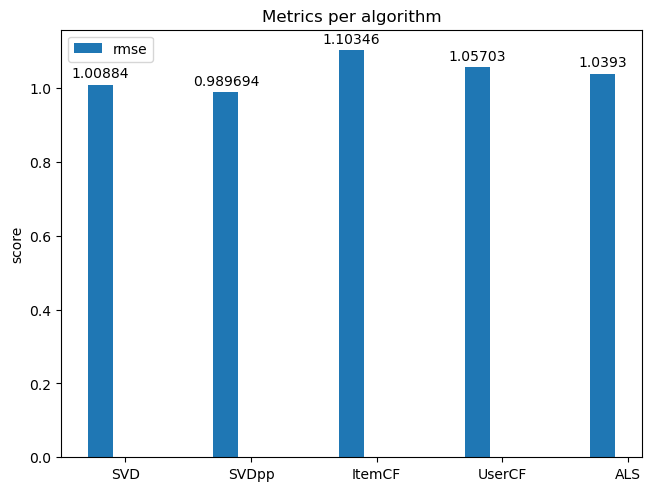

In [78]:
search_spaces = {
    'svd': svd_search,
    'svdpp': svdpp_search,
    'item_cf': item_cf_search,
    'user_cf': user_cf_search,
    'als': als_search
}

test_run5, details = run_experiment_chrono(df_data, search_spaces = search_spaces, save=True, experiment_name='test_run3', split=[0.8, 0.1, 0.1], task='rating', samples=20, tune=True)
test_figures5 = model_results_chrono(test_run5, plot_name="plot_rating")

In [79]:
day_40 = df_data['time'].min() + 86400 * 90

describe_set = df_data.loc[(df_data['time'] > day_40) & (df_data['time'] < day_40 + 86400)]['label'].describe()

describe_set

count    246.000000
mean       3.410569
std        1.033189
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: label, dtype: float64

In [80]:
df_data['label'].value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: label, dtype: int64

In [81]:
# for desc in ['count', 'mean', 'std', '75%']:
#   value_list = []
#   value_list2 = []
#   day_list = list(range(0, 210, 10))
#   for day in range(0, 210, 10):
#     day_m = df_data['time'].min() + 86400 * day
#     value_list.append(df_data.loc[(df_data['time'] > day_m) & (df_data['time'] < day_m + 86400)]['label'].describe()[desc])
#     value_list2.append(df_data.loc[(df_data['time'] <= day_m)]['label'].describe()[desc])

#   plt.figure(figsize=(10,6))

#   fig, ax = plt.subplots()

#   ax.plot(day_list, value_list, label=f'{desc}')
#   ax.plot(day_list, value_list2, label=f'time_before')

#   ax.set(xlabel='time (d)', ylabel=f'{desc}',
#         title=f'Comparison for {desc}')
#   ax.grid()
#   ax.set_xticks((range(10, 210, 20)))

#   # fig.savefig("test.png")
#   plt.legend()
#   plt.show()

In [82]:
# test_run4['40']

In [83]:
# train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1])
# eval_data = DatasetPure.build_evalset(eval_data)
# train_data, data_info = DatasetPure.build_trainset(train)
# test_data = DatasetPure.build_testset(test)

# def reset_state(name):
#     tf.compat.v1.reset_default_graph()
#     print("\n", "=" * 30, name, "=" * 30)

# def create_results(algos, test_data, metrics):

#   results = {}

#   for algo in algos:
#     print(algo)
#     result = evaluate(model=algo, data=test_data, metrics=metrics, k=20)
#     results[algo.__class__.__name__] = result

#   return results

# metrics = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# reset_state("SVD")
# svd = SVD(
#     "ranking",
#     data_info,
#     embed_size=20,
#     n_epochs=50,
#     lr=0.001,
#     reg=0.0001,
# )

# svd.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("SVD++")
# svdpp = SVDpp(
#     "ranking",
#     data_info,
#     loss_type="cross_entropy",
#     embed_size=50,
#     n_epochs=25,
#     lr=0.001,
#     reg=0.0001,
# )

# svdpp.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("item_cf")
# item_cf = ItemCF(
#     task="ranking",
#     data_info=data_info,
#     k_sim=25,
#     sim_type="pearson",
# )

# item_cf.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("user_cf")
# user_cf = UserCF(
#     task="ranking",
#     data_info=data_info,
#     k_sim=50,
#     sim_type="pearson",
# )

# user_cf.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("ALS")
# als = ALS(
#     "ranking",
#     data_info,
#     embed_size=10,
#     n_epochs=200,
#     reg=5.0
# )

# als.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# algos = [svd, svdpp, als, item_cf, user_cf]

# result = create_results(algos, test_data, metrics)

# print(result)

In [84]:
# test_figures4 = model_results(test_run4, metrics_ranking, 2, model_time=True)

In [85]:
# for algorithm, algo_values in result.items():
#   for metric, values in algo_values.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

# plt.show()

In [86]:
# result

In [87]:
# svd.__class__.__name__

In [88]:
# algos = [svd, svdpp, item_cf, user_cf, als]

# results = {}

# for algo in algos:
#   accuracy = evaluate(model=algo, data=test_data, metrics=metrics)
#   results[algo.__class__.__name__] = accuracy

In [89]:
# print(results)

In [90]:
# tf.compat.v1.reset_default_graph()

# metrics = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# als = ALS(
#     "ranking",
#     data_info,
#     reg=5.0,
#     # embed_size=20,
#     # n_epochs=50,
#     # lr=0.001,
#     # reg=0.0001,
# )



# als.fit(
#     train_data,
#     verbose=0,
#     eval_data=eval_data,
#     metrics=metrics,
# )

# accuracy = evaluate(model=als, data=test_data, metrics=metrics)

In [91]:
# print(accuracy)